In [13]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
from IPython.display import HTML, display
import matplotlib.pyplot as plt


In [2]:
model_url = "https://tfhub.dev/google/movenet/singlepose/lightning/4"
model = hub.load(model_url)
movenet = model.signatures['serving_default']

2025-05-12 12:20:12.508172: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [15]:
path = "/workspaces/Focussu-AI/data/제목 없음-1.png"
image = tf.io.read_file(path)

In [16]:
def detect_landmarks(image_path, model):
    """
    주어진 이미지 경로에서 MovNet 모델을 사용하여 랜드마크를 감지합니다.
    
    Args:
        image_path (str): 이미지 파일 경로
        model: 로드된 TensorFlow Hub MovNet 모델
        
    Returns:
        landmarks (np.ndarray): 감지된 랜드마크 (17x3 배열, keypoint_id, y, x, score)
        image (np.ndarray): 처리된 이미지
    """
    try:
        # 이미지 파일 읽기
        image_data = tf.io.read_file(image_path)
        
        # 이미지 디코딩
        image = tf.image.decode_jpeg(image_data, channels=3)
        
        # 이미지 크기 조정 (192x192)
        input_image = tf.image.resize_with_pad(image, 192, 192)
        
        # 입력 형식에 맞게 변환 (배치 차원 추가 및 정규화)
        input_image = tf.cast(input_image, dtype=tf.int32)
        input_image = input_image[tf.newaxis, ...]
        
        # 모델 추론
        results = model(input_image)
        
        # 결과 추출 (키포인트)
        keypoints = results['output_0'].numpy()
        keypoints = keypoints[0, 0, :, :]  # 첫 번째 사람의 키포인트
        
        print(f"감지된 랜드마크 형태: {keypoints.shape}")
        
        return keypoints, image.numpy()
        
    except Exception as e:
        print(f"오류 발생: {e}")
        return None, None



In [17]:
a, b = detect_landmarks(path, movenet)

감지된 랜드마크 형태: (17, 3)


In [11]:

def visualize_landmarks(image, keypoints):
    """
    이미지에 감지된 랜드마크를 시각화합니다.
    
    Args:
        image (np.ndarray): 원본 이미지
        keypoints (np.ndarray): MovNet에서 감지한 키포인트 (17x3 배열)
    """
    height, width, _ = image.shape
    
    # 키포인트 연결 정의 (COCO 형식)
    connections = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # 얼굴
        (5, 7), (7, 9), (6, 8), (8, 10),  # 팔
        (5, 6), (5, 11), (6, 12),  # 어깨와 엉덩이
        (11, 12), (11, 13), (13, 15), (12, 14), (14, 16)  # 다리
    ]
    
    # 키포인트 색상 및 연결 색상
    keypoint_color = (0, 255, 0)  # 녹색
    connection_color = (255, 0, 0)  # 빨간색
    
    # 결과 이미지 복사
    result_image = image.copy()
    
    # 키포인트 그리기
    for y, x, confidence in keypoints:
        if confidence > 0.3:  # 신뢰도 임계값
            y_px = int(y * height)
            x_px = int(x * width)
            cv2.circle(result_image, (x_px, y_px), 5, keypoint_color, -1)
    
    # 연결선 그리기
    for connection in connections:
        start_idx, end_idx = connection
        start_y, start_x, start_conf = keypoints[start_idx]
        end_y, end_x, end_conf = keypoints[end_idx]
        
        if start_conf > 0.3 and end_conf > 0.3:
            start_y_px = int(start_y * height)
            start_x_px = int(start_x * width)
            end_y_px = int(end_y * height)
            end_x_px = int(end_x * width)
            
            cv2.line(result_image, (start_x_px, start_y_px), (end_x_px, end_y_px), connection_color, 2)
    
    # 결과 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('감지된 포즈 랜드마크')
    plt.show()
    
    return result_image

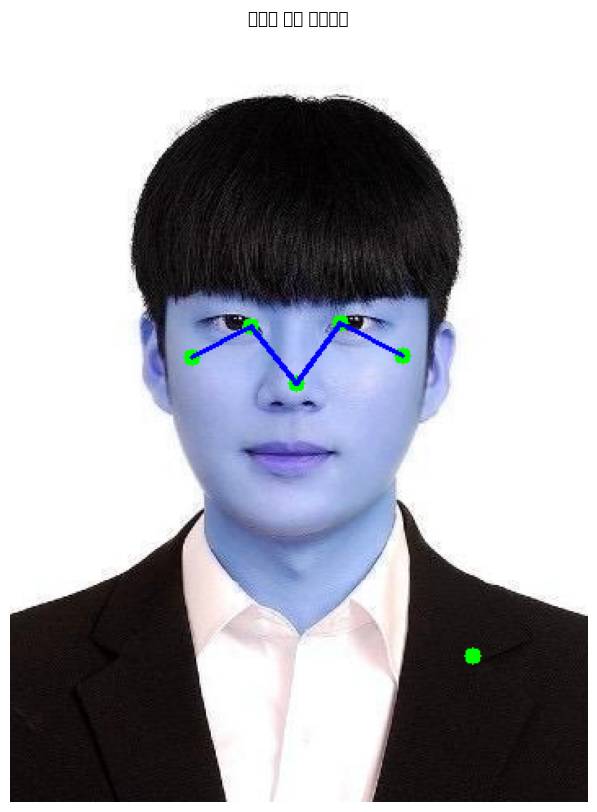

In [18]:
# 시각화 실행
if a is not None:
    visualize_landmarks(b, a)